### Installing dependencies

In [150]:
"""
Install required packages using pip.

Packages:
- pandas
- seaborn
- matplotlib
- scikit-learn
- numpy
- openpyxl
- pipenv

Usage: %pip install pandas seaborn matplotlib scikit-learn numpy openpyxl pipenv
"""
%pip install pandas seaborn matplotlib scikit-learn numpy openpyxl pipenv umap-learn

Note: you may need to restart the kernel to use updated packages.


### Importing the necessary libraries for the workflow.

In [151]:
"""
Installed packages are loaded using the import statement. The # type: ignore comment is used to suppress warnings.
"""
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import os # type: ignore
import re # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.decomposition import PCA # type: ignore
from sklearn.experimental import enable_iterative_imputer  # type: ignore
from sklearn.impute import IterativeImputer  # type: ignore

### Loading data

In [152]:
"""
Load data from an Excel file and extract specific features.
"""

# Specify the run. 


print("Loading data...")
data = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", engine='openpyxl')
#data_extracted_features = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", usecols=['Batch number', 'Genotype Neuron', 'Div calculated', 'Culture treatment', 'Capacitance', 'Input Resistance', 'Resting membrane potential ', 'Maximum firing ', 'Calculated input resistance', 'Rheobase', 'EPSC freq'])
data_extracted_features = pd.read_excel("data/01. Master_Latest data_Control clones_LP.xlsx", usecols=['Batch number', 'Genotype Neuron', 'Div calculated', 'Culture treatment', 'Cultured by', 'Capacitance', 'Input Resistance', 'Resting membrane potential ', 'Maximum firing ', 'Rheobase', 'EPSC freq'])

print("\n")
print(data_extracted_features)

Loading data...


     Batch number Genotype Neuron  Div calculated   Culture treatment  \
0               1         TSC12.3              33                none   
1               1         TSC12.3              33                none   
2               1         TSC12.3              33                none   
3               1         TSC12.3              33                none   
4               1         TSC12.3              33                none   
..            ...             ...             ...                 ...   
683             3             WTC              58                none   
684             3             WTC              58  microglia 6 weekes   
685             3             WTC              58                none   
686             3             WTC              58                none   
687             3             WTC              58  microglia 6 weekes   

                                     Cultured by  Capacitance  \
0    Set-up: Ilse (?), Cultured: Ilse/Na

### Preprocessing data

### Violin plot before preprocessing

Plotting Batch number...


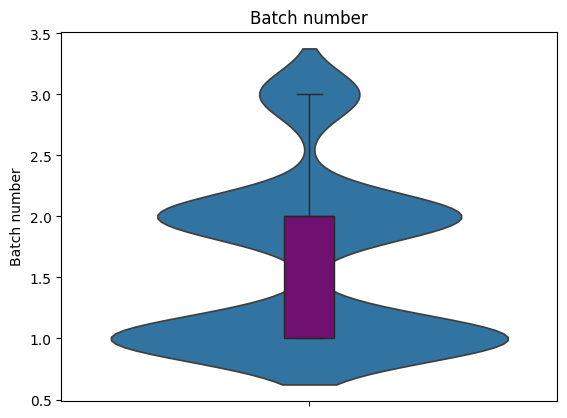

Plotting Genotype Neuron...


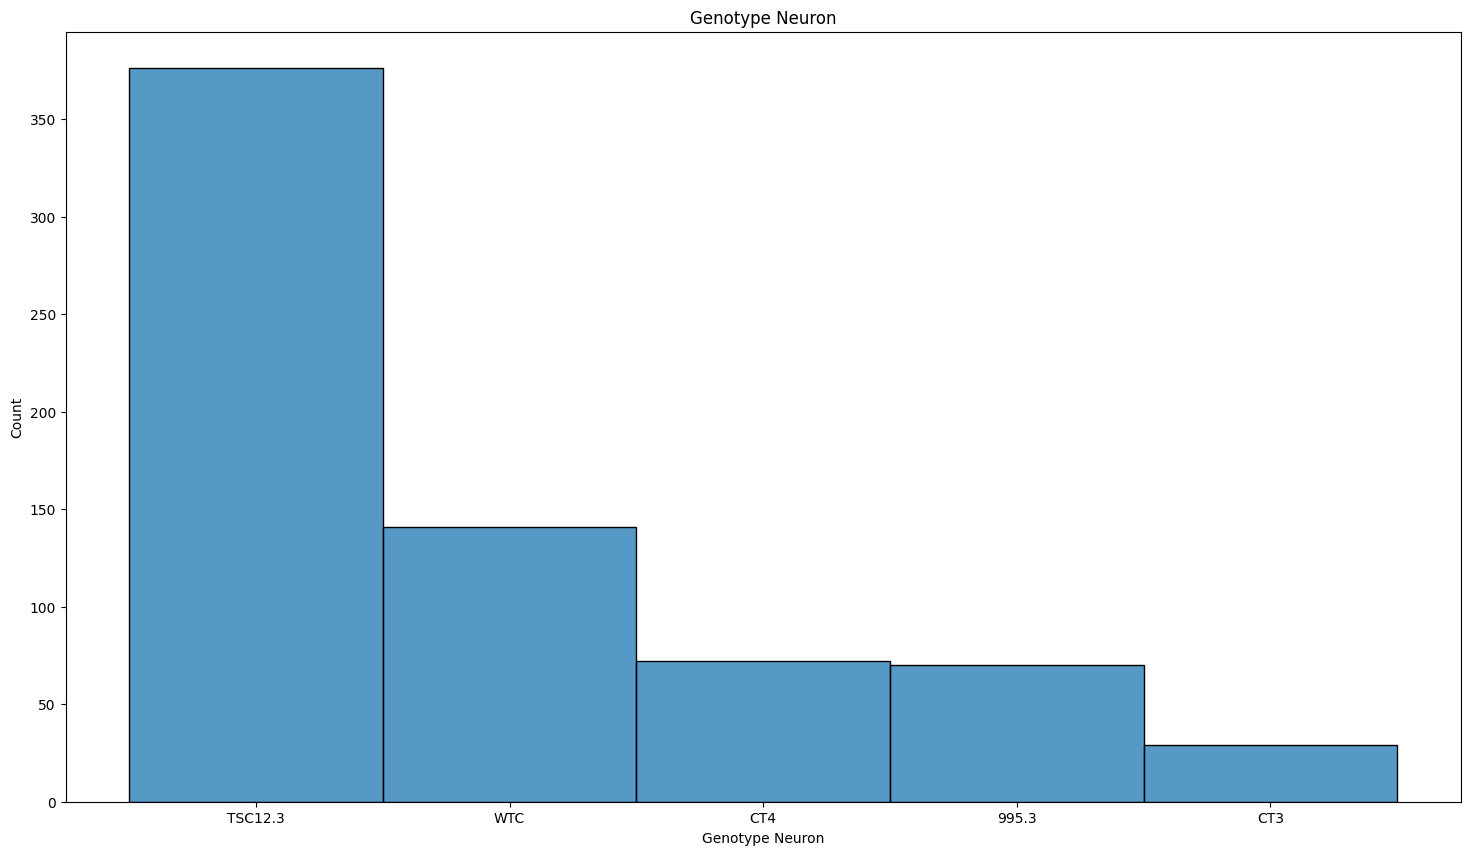

Plotting Div calculated...


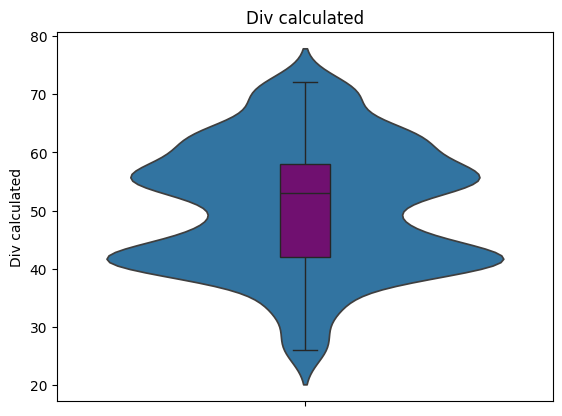

Plotting Culture treatment...


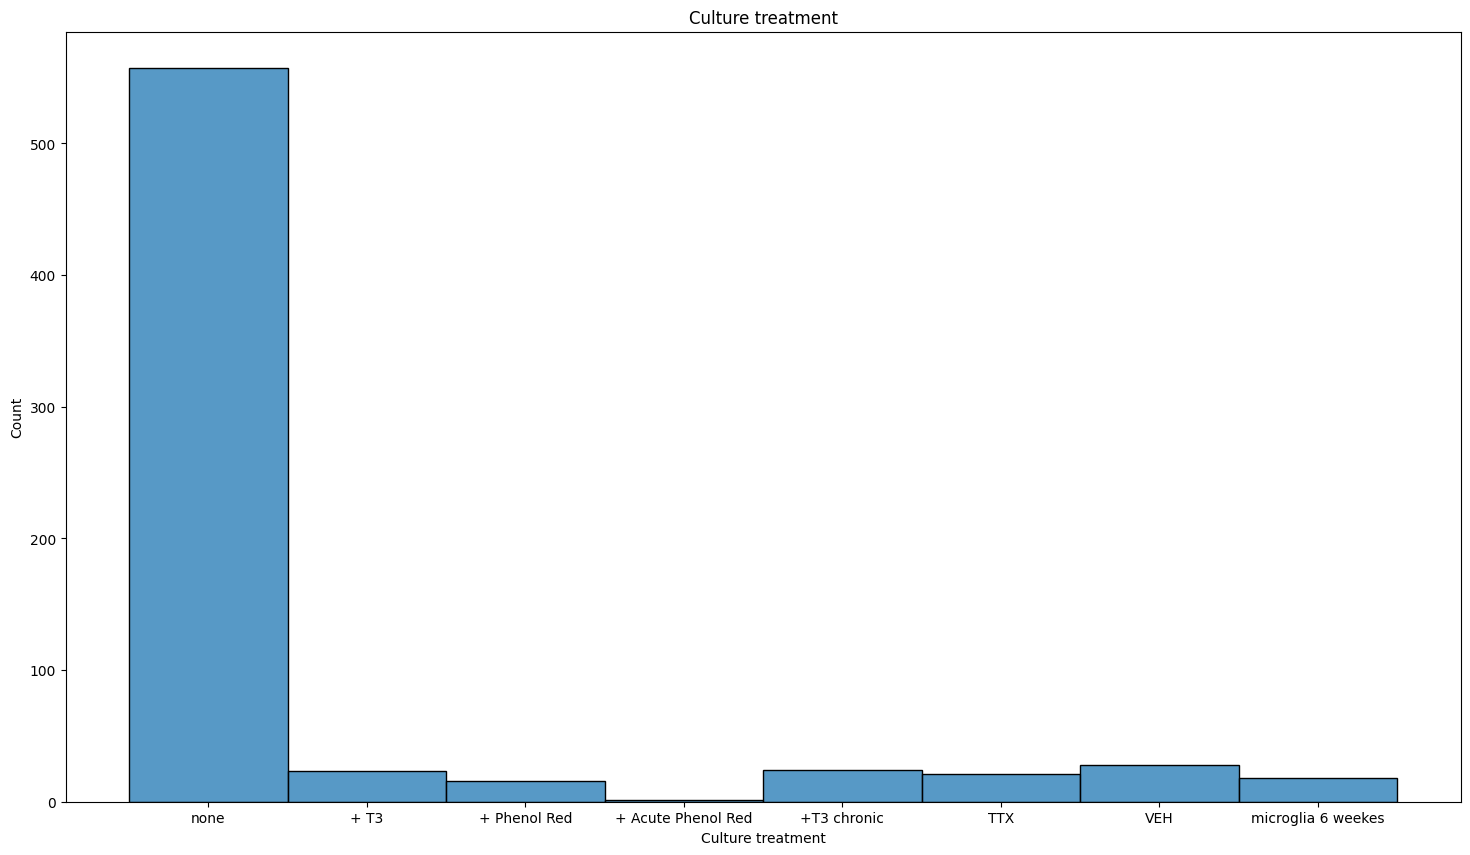

Plotting Cultured by...


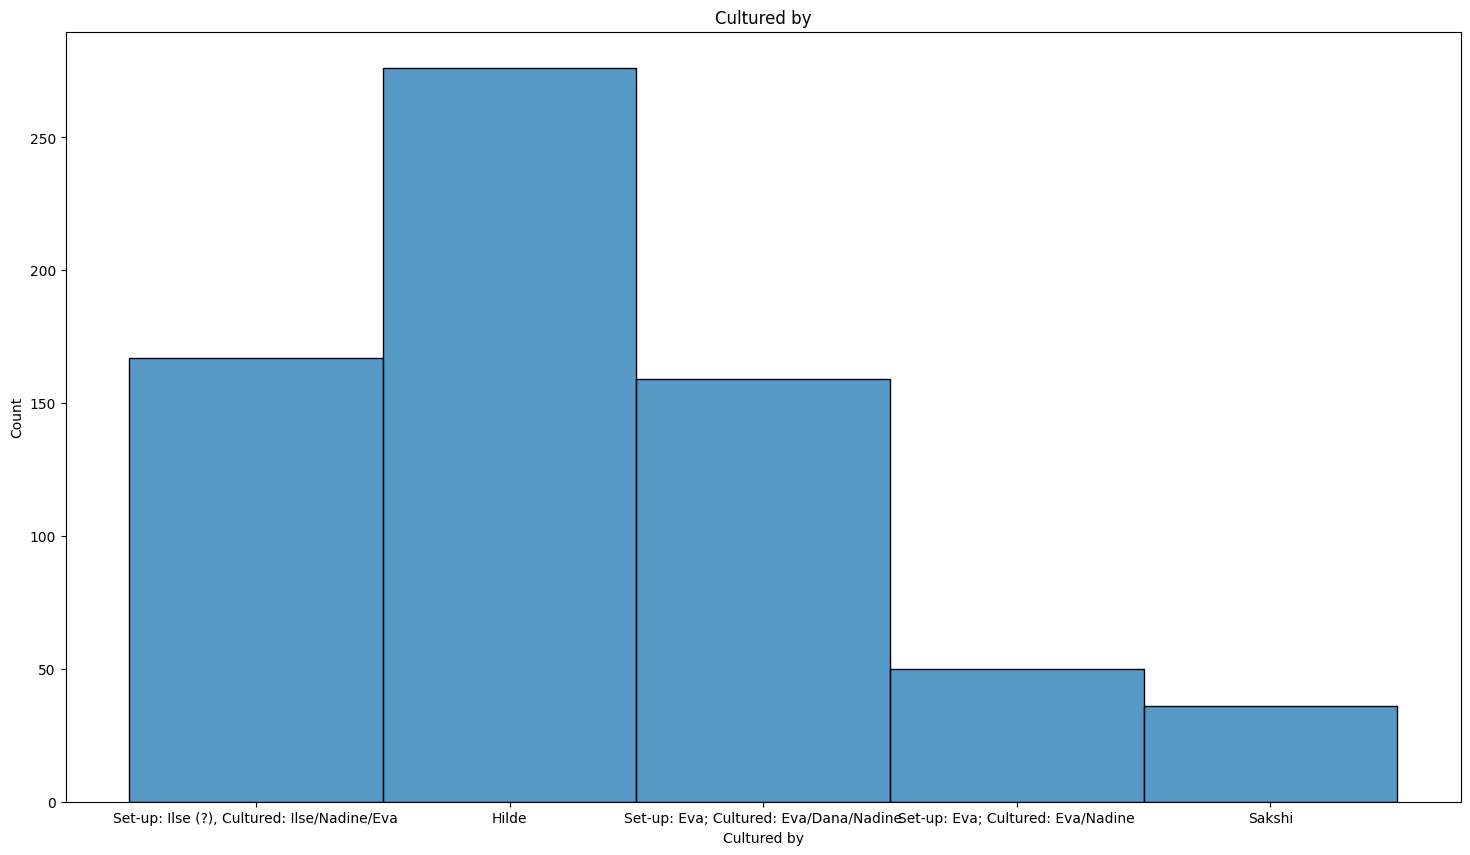

Plotting Capacitance...


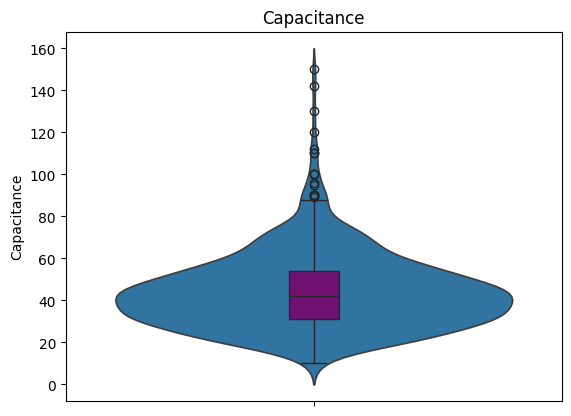

Plotting Input Resistance...


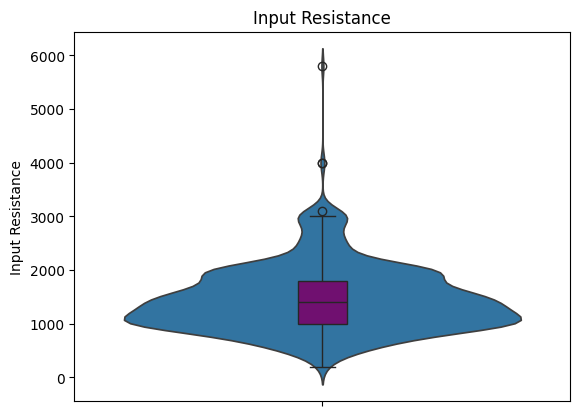

Plotting Resting membrane potential ...


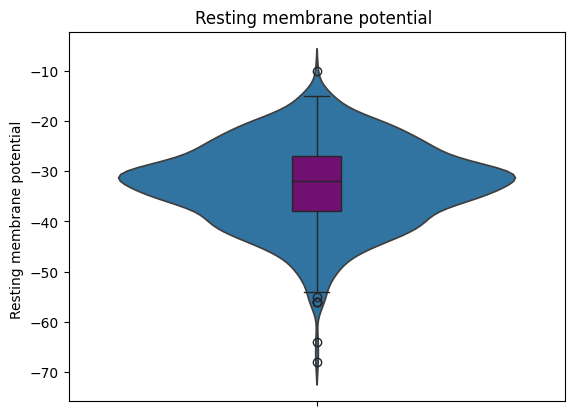

Plotting Maximum firing ...


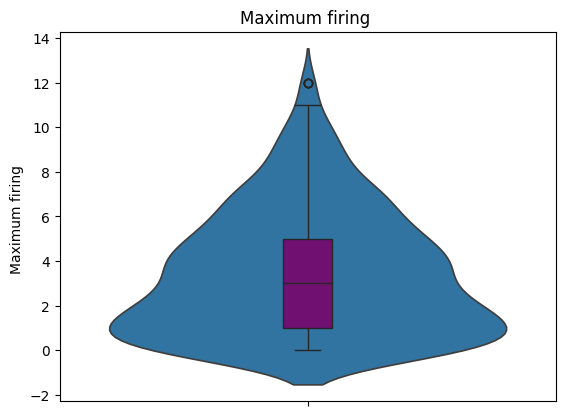

Plotting Rheobase...


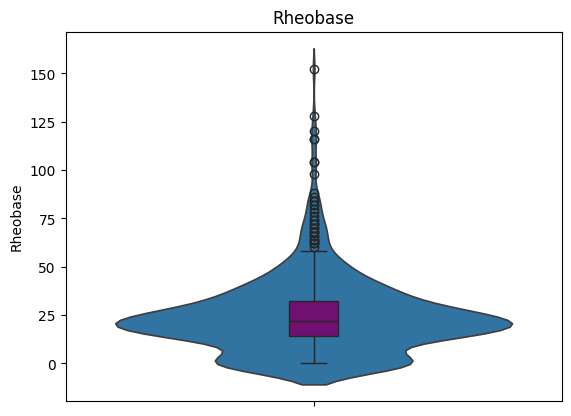

Plotting EPSC freq...


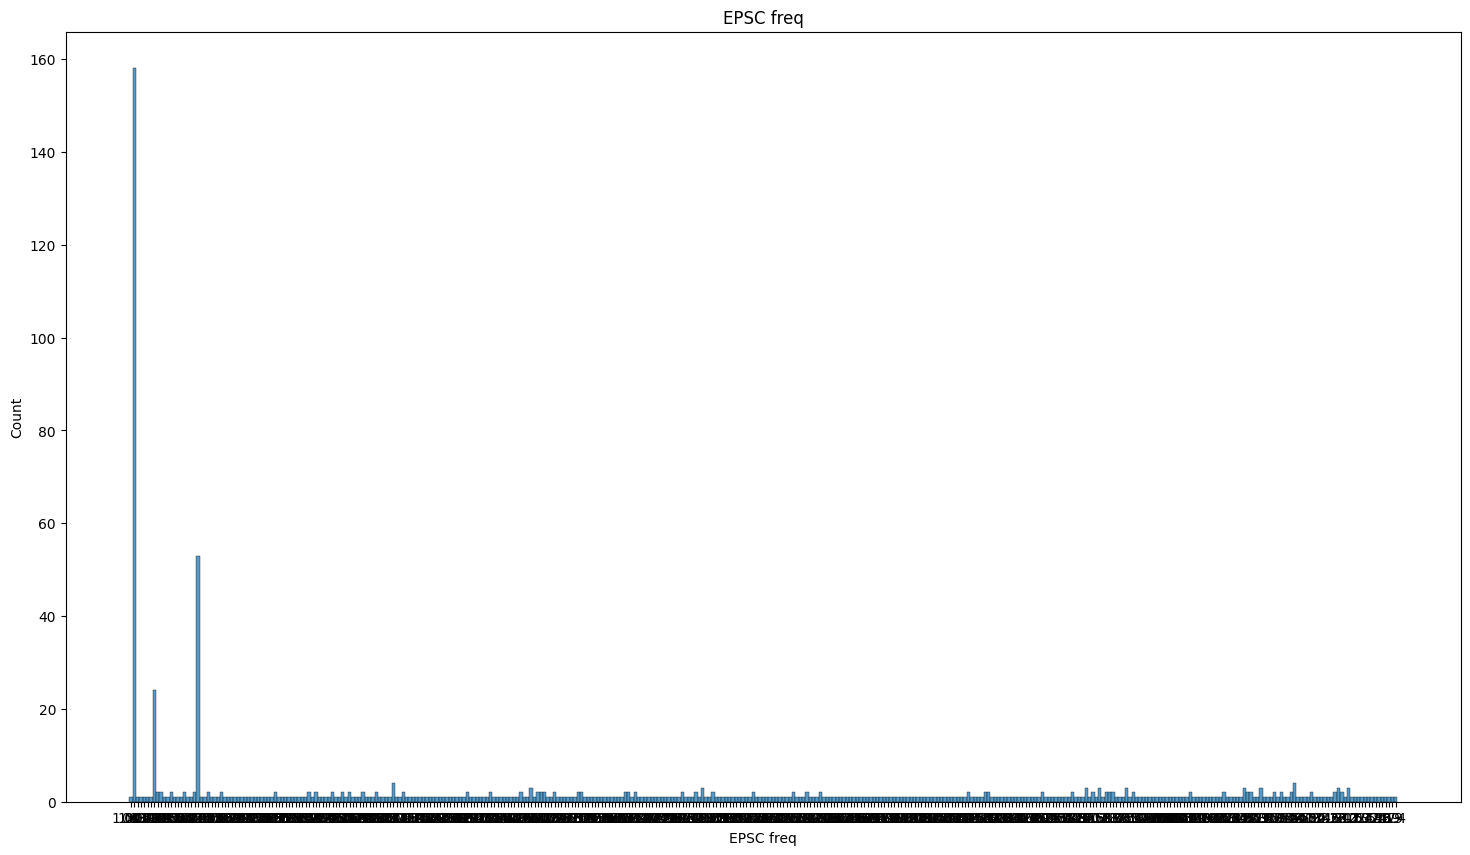

In [153]:
"""
Plots violin and box plots for each feature in the given DataFrame.
"""

# Create a copy of the DataFrame
data_extracted_features_violin_pre = data_extracted_features.copy()

# # Convert 'EPSC freq' to numeric
# data_extracted_features_violin_pre['EPSC freq'] = pd.to_numeric(data_extracted_features_violin_pre['EPSC freq'])

# # Create subplots
# fig, axes = plt.subplots(4, 3, figsize=(30, 30))
# axes = axes.flatten()

# # Iterate over each feature in the DataFrame
# for i, feature in enumerate(data_extracted_features_violin_pre.columns): 
#     if feature == 'Batch number':
#         i-=1
#         continue
#     elif feature == 'Genotype Neuron':
#         # Plot violin and box plots for 'Genotype Neuron'
#         sns.violinplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], inner=None)
#         sns.boxplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], width=0.1, color="purple", meanline=True)
#         axes[i].set_title(feature)
#     elif feature == 'Culture treatment':
#         # Plot violin and box plots for 'Culture treatment'
#         sns.violinplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], inner=None)
#         sns.boxplot(x=feature, y='Batch number', data=data_extracted_features_violin_pre, ax=axes[i], width=0.1, color="purple", meanline=True)
#         axes[i].set_title(feature)
#     else:
#         # Plot violin and box plots for other features
#         sns.violinplot(x='Batch number', y=feature, data=data_extracted_features_violin_pre, ax=axes[i], inner=None)
#         sns.boxplot(x='Batch number', y=feature, data=data_extracted_features_violin_pre, ax=axes[i], width=0.1, color="purple", meanline=True)
#         axes[i].set_title(feature)

#print(data_extracted_features_violin_pre['Genotype Neuron'].value_counts())
#sns.histplot(data=data_extracted_features_violin_pre['Genotype Neuron'])
#plt.show()   

for i, feature in enumerate(data_extracted_features_violin_pre.columns): 
    print(f"Plotting {feature}...")
    if not os.path.exists('run_1/qc/plots/raw'):
        os.makedirs('run_1/qc/plots/raw')
    if data_extracted_features_violin_pre[feature].dtype == 'object':
        # Plot violin and box plots for categorical features
        plt.figure(figsize=(18, 10))
        sns.histplot(data=data_extracted_features_violin_pre[feature].astype(str))
        plt.title(feature)
        plt.savefig(f"run_1/qc/plots/raw/{'_'.join(feature.split(' '))}_hist.png")
        plt.show()
        #sns.boxplot(data=data_extracted_features_violin_pre, width=0.1, color="purple", meanline=True)
    else:
        # Plot violin and box plots for other features
        sns.violinplot(data=data_extracted_features_violin_pre[feature], inner=None)
        sns.boxplot(data=data_extracted_features_violin_pre[feature], width=0.1, color="purple", meanline=True)
        plt.title(feature)
        plt.savefig(f"run_1/qc/plots/raw/{'_'.join(feature.split(' '))}_violin.png")
        plt.show()


#sns.histplot(data=data_extracted_features_violin_pre['Culture treatment'])   
# Plot violin and box plots for 'EPSC freq' feature
#sns.violinplot(data=data_extracted_features_violin_pre["Div calculated"], inner=None)

# for feature in data_extracted_features_violin_pre.columns:
#     sns.violinplot(data=data_extracted_features_violin_pre[feature], inner=None)

# Adjust the layout and display the plot
#plt.tight_layout()
# plt.show()


In [154]:
# data_extracted_features_ranges = data_extracted_features.copy()
# mask = data_extracted_features_ranges['EPSC freq'].notna() & data_extracted_features_ranges['EPSC freq'].str.contains(">")
# data_extracted_features_ranges = data_extracted_features_ranges.loc[mask, 'EPSC freq']

# for item in data_extracted_features_ranges: 
#     item = item.strip(">").replace("<", '')
#     print(item)

### MICE imputation

In [155]:
"""
Imputes missing values in the given DataFrame using the IterativeImputer algorithm.
"""

#Create copy of the DataFrame
data_extracted_features_impute = data_extracted_features.copy() 

# Replace '>' values with NaN in 'EPSC freq' column
mask = data_extracted_features_impute['EPSC freq'].notna() & data_extracted_features_impute['EPSC freq'].str.contains(">")
data_extracted_features_impute.loc[mask, 'EPSC freq'] = np.nan

# # Convert 'EPSC freq' column to numeric
data_extracted_features_impute['EPSC freq'] = pd.to_numeric(data_extracted_features_impute['EPSC freq'])


# Initialize the IterativeImputer
imputer = IterativeImputer(random_state=0, min_value=0, sample_posterior=False, max_iter=100, tol=0.001)
# sample_posterior=True

# min_value uiteindleijk op 0
# tol (tolerance) uitgelegd vanuit algoritme/paper 
# sample_posterior uitgelegd vanuit algoritme/paper`
# max iter hoger (100, 1000), kijk naar verschil imputatie waardes 

# Drop object columns for imputation. The columns which contain categorical values will be dropped for the MICE imputation to work.
# These columns will be added back after imputation.
object_columns = data_extracted_features_impute.select_dtypes(include=['object']).columns
data_extracted_features_impute_copy = data_extracted_features_impute.drop(columns=object_columns)

# Impute missing values
data_extracted_features_imputed = imputer.fit_transform(data_extracted_features_impute_copy)
data_extracted_features_imputed = pd.DataFrame(data_extracted_features_imputed, columns=data_extracted_features_impute_copy.columns)

# Add back the object columns
for column in object_columns:
    data_extracted_features_imputed[column] = data_extracted_features_impute[column]

# Create dictioniary to store imputed values to be exported to Excel
dict_imputed_values = {
    'Feature': [],
    'Index': [],
    'Original Value': [],
    'Imputed Value': []
}

# Print imputed values for each column
for column in data_extracted_features_impute.columns:
    missing_mask_column = data_extracted_features_impute[column].isnull()
    imputed_missing_mask_column = data_extracted_features_imputed[column].isnull()
    imputed_values_mask_column = (missing_mask_column) & (~imputed_missing_mask_column)
    imputed_values_column = data_extracted_features_impute.loc[imputed_values_mask_column, column]
    imputed_value = data_extracted_features_imputed.loc[imputed_values_mask_column, column]
    if not imputed_values_column.empty:
        if not os.path.exists('run_1/qc/tables/MICE_imputation'):
            os.makedirs('run_1/qc/tables/MICE_imputation')
        imputed_value_pairs = [(original, imputed) for original, imputed in zip(imputed_values_column, imputed_value)]
        formatted_output = "\n".join([f"Index: {index + 2}\nOriginal Value: {original} --> Imputed value: {imputed}" for index, (original, imputed) in zip(imputed_values_column.index, imputed_value_pairs)])
        print(formatted_output + "\n")
        # Store imputed values in dictionary
        indices = imputed_values_mask_column[imputed_values_mask_column].index
        dict_imputed_values['Feature'].extend([column] * len(indices))
        dict_imputed_values['Index'].extend(indices + 2)  # Adding 2 to match your index adjustment
        dict_imputed_values['Original Value'].extend(imputed_values_column.fillna('nan').tolist())
        dict_imputed_values['Imputed Value'].extend(imputed_value.tolist())
        #print(dict_imputed_values)

# Export imputed values to Excel
imputed_df = pd.DataFrame(dict_imputed_values)  
imputed_df.to_csv(f"run_1/qc/tables/MICE_imputation/MICE_imputed_values_0_FALSE_{100}.csv", index=False)
        # Change negative frequencies to 0
        #data_extracted_features_imputed["EPSC freq"].loc[data_extracted_features_imputed["EPSC freq"] < 0] = 0


Index: 651
Original Value: nan --> Imputed value: 1466.167696462265

Index: 632
Original Value: nan --> Imputed value: 2.2005210848869
Index: 637
Original Value: nan --> Imputed value: 2.395739636908261

Index: 452
Original Value: nan --> Imputed value: 31.001103513574673

Index: 27
Original Value: nan --> Imputed value: 0.5369298251648332
Index: 49
Original Value: nan --> Imputed value: 0.1377523495720544
Index: 52
Original Value: nan --> Imputed value: 0.0
Index: 56
Original Value: nan --> Imputed value: 0.96060651305173
Index: 57
Original Value: nan --> Imputed value: 0.015885209623630492
Index: 60
Original Value: nan --> Imputed value: 0.8281488505263931
Index: 61
Original Value: nan --> Imputed value: 0.34442872867283947
Index: 62
Original Value: nan --> Imputed value: 0.5615120228356675
Index: 64
Original Value: nan --> Imputed value: 0.06725870090869646
Index: 66
Original Value: nan --> Imputed value: 0.3188403830959624
Index: 73
Original Value: nan --> Imputed value: 0.72646562

### Violin plot after preprocessing

Plotting Batch number...


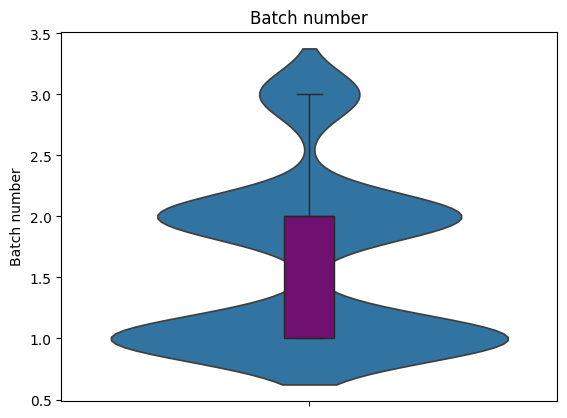

Plotting Div calculated...


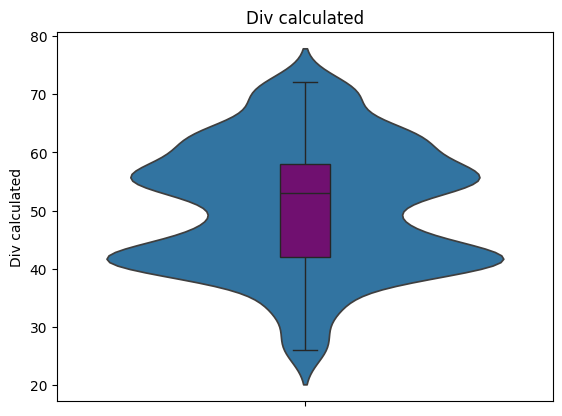

Plotting Capacitance...


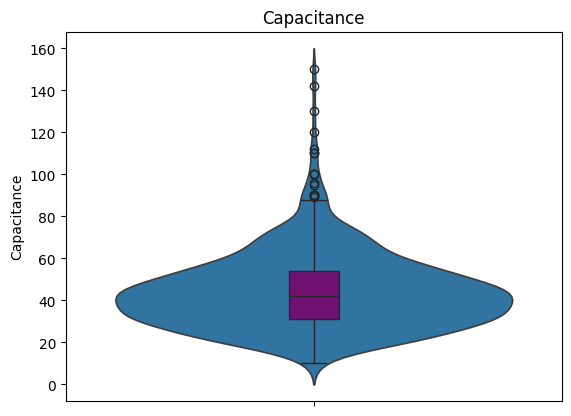

Plotting Input Resistance...


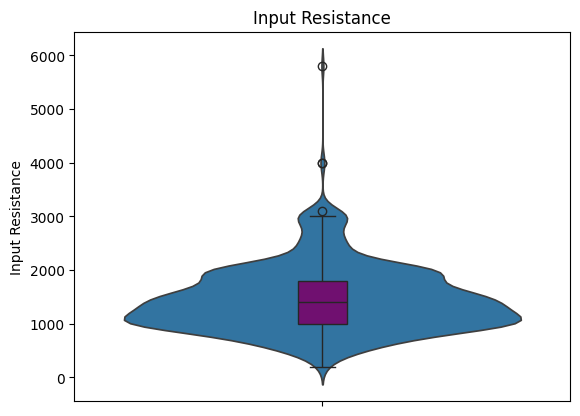

In [156]:

"""
Plots violin and box plots for each feature against the 'Batch number' column.
"""

for i, feature in enumerate(data_extracted_features_imputed.columns): 
    print(f"Plotting {feature}...")
    if not os.path.exists('run_1/qc/plots/imputed'):
        os.makedirs('run_1/qc/plots/imputed')
    if data_extracted_features_imputed[feature].dtype == 'object':
        # Plot violin and box plots for categorical features
        plt.figure(figsize=(18, 10))
        sns.histplot(data=data_extracted_features_imputed[feature].astype(str))
        plt.title(feature)
        plt.savefig(f"run_1/qc/plots/imputed/{'_'.join(feature.split(' '))}_hist.png")
        plt.show()
        #sns.boxplot(data=data_extracted_features_violin_pre, width=0.1, color="purple", meanline=True)
    else:
        # Plot violin and box plots for other features
        sns.violinplot(data=data_extracted_features_imputed[feature], inner=None)
        sns.boxplot(data=data_extracted_features_imputed[feature], width=0.1, color="purple", meanline=True)
        plt.title(feature)
        plt.savefig(f"run_1/qc/plots/imputed/{'_'.join(feature.split(' '))}_violin.png")
        plt.show()

# Adjust the layout and display the plot
# plt.tight_layout()
# plt.show()


## GLM imputation

In [ ]:
from sklearn.linear_model import LinearRegression

# Assuming 'data_extracted_features' is your input dataframe
data_extracted_features_impute_glm = data_extracted_features.copy()

# Handle 'EPSC freq' values
mask_glm = data_extracted_features_impute_glm['EPSC freq'].notna() & data_extracted_features_impute_glm['EPSC freq'].str.contains(">")
data_extracted_features_impute_glm.loc[mask_glm, 'EPSC freq'] = np.nan

# Convert 'EPSC freq' to numeric, setting errors='coerce' to handle any unexpected values
data_extracted_features_impute_glm['EPSC freq'] = pd.to_numeric(data_extracted_features_impute_glm['EPSC freq'], errors='coerce')

# Drop object columns for imputation
object_columns_glm = data_extracted_features_impute_glm.select_dtypes(include=['object']).columns
data_extracted_features_impute_glm_copy = data_extracted_features_impute_glm.drop(columns=object_columns_glm)

# Set up the imputer with LinearRegression estimator
imputer_glm = IterativeImputer(estimator=LinearRegression(), random_state=0)

# Fit the imputer to your data and transform it
data_extracted_features_imputed_glm = imputer_glm.fit_transform(data_extracted_features_impute_glm_copy)
data_extracted_features_imputed_glm = pd.DataFrame(data_extracted_features_imputed_glm, columns=data_extracted_features_impute_glm_copy.columns)

# Add back the object columns
for column in object_columns_glm:
    data_extracted_features_imputed_glm[column] = data_extracted_features_impute_glm[column]

# Create dictioniary to store imputed values to be exported to Excel
dict_imputed_glm_values = {
    'Feature': [],
    'Index': [],
    'Original Value': [],
    'Imputed Value': []
}

# Print imputed values for each column
for column_glm in data_extracted_features_impute_glm_copy.columns:
    missing_mask_column_glm = data_extracted_features_impute_glm_copy[column_glm].isnull()
    imputed_missing_mask_column_glm = data_extracted_features_imputed_glm[column_glm].isnull()
    imputed_values_mask_column_glm = missing_mask_column_glm & ~imputed_missing_mask_column_glm
    imputed_values_column_glm = data_extracted_features_impute_glm_copy.loc[imputed_values_mask_column_glm, column_glm]
    imputed_value_glm = data_extracted_features_imputed_glm.loc[imputed_values_mask_column_glm, column_glm]
    if not imputed_values_column_glm.empty:
        if not os.path.exists('run_1/qc/tables/GLM_imputation'):
            os.makedirs('run_1/qc/tables/GLM_imputation')
        imputed_value_pairs_glm = [(original_glm, imputed_glm) for original_glm, imputed_glm in zip(imputed_values_column_glm, imputed_value_glm)]
        print(f"Imputed values for {column_glm}:")
        formatted_output = "\n".join([f"Index: {index_glm + 2}\nOriginal Value: {original_glm} --> Imputed value: {imputed_glm}" for index_glm, (original_glm, imputed_glm) in zip(imputed_values_column_glm.index, imputed_value_pairs_glm)])
        print(formatted_output + "\n")
        # Store imputed values in dictionary
        indices_glm = imputed_values_mask_column[imputed_values_mask_column_glm].index
        dict_imputed_glm_values['Feature'].extend([column_glm] * len(indices_glm))
        dict_imputed_glm_values['Index'].extend(indices_glm + 2)  # Adding 2 to match your index adjustment
        dict_imputed_glm_values['Original Value'].extend(imputed_values_column_glm.fillna('nan').tolist())
        dict_imputed_glm_values['Imputed Value'].extend(imputed_value_glm.tolist())
        #print(dict_imputed_values)

# Export imputed values to Excel
imputed_df_glm = pd.DataFrame(dict_imputed_glm_values)  
imputed_df_glm.to_csv(f"run_1/qc/tables/GLM_imputation/GLM_imputed_values_0_FALSE_100.csv", index=False)


Imputed values for Input Resistance:
Index: 651
Original Value: nan --> Imputed value: 1460.7101189089092

Imputed values for Maximum firing :
Index: 632
Original Value: nan --> Imputed value: 2.2290887931806163
Index: 637
Original Value: nan --> Imputed value: 2.4354552022603406

Imputed values for Rheobase:
Index: 452
Original Value: nan --> Imputed value: 30.522523422575023

Imputed values for EPSC freq:
Index: 27
Original Value: nan --> Imputed value: 0.46250754256933113
Index: 49
Original Value: nan --> Imputed value: 0.05891263592687679
Index: 52
Original Value: nan --> Imputed value: -0.14252353128277206
Index: 56
Original Value: nan --> Imputed value: 0.9527428971077986
Index: 57
Original Value: nan --> Imputed value: -0.003611902458125593
Index: 60
Original Value: nan --> Imputed value: 0.7497175061958733
Index: 61
Original Value: nan --> Imputed value: 0.289990348808583
Index: 62
Original Value: nan --> Imputed value: 0.5072384700234617
Index: 64
Original Value: nan --> Imput

## Unsupervised learning

In [ ]:
# from sklearn.decomposition import PCA

# data_extracted_features_imputed_labeled = data_extracted_features_imputed.copy()
# object_columns_pca = list(data_extracted_features_impute.select_dtypes(include=['object']).columns)
# object_columns_pca.append("Batch number")
# # print(object_columns_pca)   
# #print(data_extracted_features_imputed_labeled.columns)
# data_extracted_features_imputed_labeled.drop(columns=object_columns_pca, inplace=True)    


# # # Assuming 'categorical_column' is the name of the column containing categorical variables
# # label_encoder = LabelEncoder()
# # data_extracted_features_imputed_labeled['Genotype Neuron'] = label_encoder.fit_transform(data_extracted_features_imputed_labeled['Genotype Neuron'].astype(str))  
# # print(f"Original values: {label_encoder.classes_}\n Label encoded values: {data_extracted_features_imputed_labeled['Genotype Neuron'].unique()}")
# # data_extracted_features_imputed_labeled['Culture treatment'] = label_encoder.fit_transform(data_extracted_features_imputed_labeled['Culture treatment'])  
# # print(f"Original values: {label_encoder.classes_}\n Label encoded values: {data_extracted_features_imputed_labeled['Culture treatment'].unique()}")

# # Assuming data is your dataset
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(data_extracted_features_imputed_labeled)

# fig, axes = plt.subplots(1, 3, figsize=(25, 10))
# axes = axes.flatten()

# for i, feature in enumerate(object_columns_pca):
#     sns.scatterplot(data=pd.DataFrame(reduced_data), x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data_extracted_features_imputed[feature], ax=axes[i])
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.title('PCA Plot')

# plt.tight_layout()
# plt.show()


## K means clustering

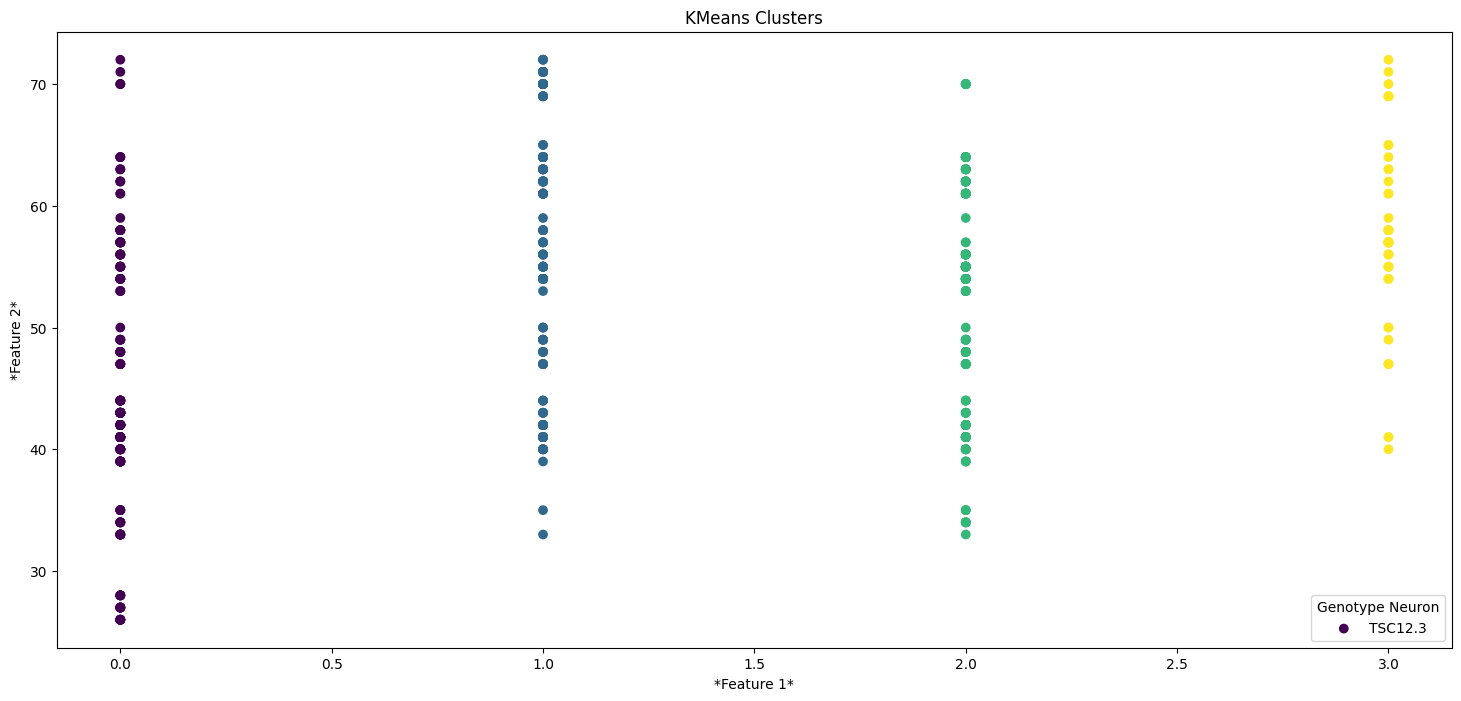

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import LabelEncoder

# data_extracted_features_imputed_kmeans_labeled = data_extracted_features_imputed.copy() 

# print(data_extracted_features_imputed_kmeans_labeled.columns)   

# X_train, X_test= train_test_split(data_extracted_features_imputed_kmeans_labeled, test_size=0.2, random_state=0)

# label_encoder = LabelEncoder()
# X_train['Genotype Neuron'] = label_encoder.fit_transform(X_train['Genotype Neuron'].astype(str))  
# print(f"Original values: {' '.join(label_encoder.classes_)}\n Label encoded values: {X_train['Genotype Neuron'].unique()}")
# X_train['Culture treatment'] = label_encoder.fit_transform(X_train['Culture treatment'])  
# print(f"Original values: {' '.join(label_encoder.classes_)}\n Label encoded values: {X_train['Culture treatment'].unique()}")

# data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'] = label_encoder.fit_transform(data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'].astype(str))  
# print(f"Original values: {' '.join(label_encoder.classes_)}\n Label encoded values: {data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'].unique()}")
# data_extracted_features_imputed_kmeans_labeled['Culture treatment'] = label_encoder.fit_transform(data_extracted_features_imputed_kmeans_labeled['Culture treatment'])  
# print(f"Original values: {' '.join(label_encoder.classes_)}\n Label encoded values: {data_extracted_features_imputed_kmeans_labeled['Culture treatment'].unique()}")

# kmeans = KMeans(n_clusters=2, random_state=0)

# # Fit the KMeans model to the data
# kmeans.fit(X_train)

# cluster_labels = kmeans.labels_
# print(f"Cluster labels: \n{np.unique(cluster_labels)}")   

# # Add the cluster labels to your DataFrame
# X_train['Cluster'] = cluster_labels
# #print(data_extracted_features_imputed_kmeans_labeled['Cluster'])

# # Print the counts of samples in each cluster
# print(X_train['Cluster'].value_counts())


# plt.figure(figsize=(20, 6))
# sns.boxplot(data= data_extracted_features_imputed_kmeans_labeled, x=X_train["Div calculated"], y= data_extracted_features_imputed_kmeans_labeled["Div calculated"])  
# plt.xlabel('Div calculated')
# plt.ylabel('Div calculated')
# plt.title('K-means Clustering')
# plt.legend(labels=['Cluster 0', 'Cluster 1'], loc='upper right', title='Cluster')
# plt.show()

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

data_extracted_features_imputed_kmeans_labeled = data_extracted_features_imputed.copy() 

# data_extracted_features_imputed_kmeans_labeled_features = data_extracted_features_imputed_kmeans_labeled.drop(columns=['Div calculated'])
# div_column = data_extracted_features_imputed_kmeans_labeled['Div calculated']

# label_encoder = LabelEncoder()
# data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'] = label_encoder.fit_transform(data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'].astype(str))  
# genotype_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))  
# print(f"Original values: {' '.join(label_encoder.classes_)}\n Label encoded values: {data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'].unique()}")
# data_extracted_features_imputed_kmeans_labeled['Culture treatment'] = label_encoder.fit_transform(data_extracted_features_imputed_kmeans_labeled['Culture treatment'])  
# culture_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print(f"Original values: {' '.join(label_encoder.classes_)}\n Label encoded values: {data_extracted_features_imputed_kmeans_labeled['Culture treatment'].unique()}")

data_extracted_features_imputed_kmeans_labeled_features_numeric = data_extracted_features_imputed_kmeans_labeled.select_dtypes(include=['float64', 'int64'])   

# print(data_extracted_features_imputed_kmeans_labeled_features_numeric)
# print(genotype_dict)
# print(culture_dict)

#print(data_extracted_features_imputed_kmeans_labeled)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_extracted_features_imputed_kmeans_labeled_features_numeric)

kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(scaled_features)

clusters = kmeans.predict(scaled_features)

data_extracted_features_imputed_kmeans_labeled['cluster'] = clusters

plt.figure(figsize=(18, 8))
plt.scatter(data_extracted_features_imputed_kmeans_labeled['cluster'], data_extracted_features_imputed_kmeans_labeled['Div calculated'], c=data_extracted_features_imputed_kmeans_labeled['cluster'], cmap='viridis')

# plt.gca().add_artist(legend1)

plt.title('KMeans Clusters')
plt.xlabel('*Feature 1*')
plt.ylabel('*Feature 2*')
plt.legend(title='Genotype Neuron', loc='best', labels=data_extracted_features_imputed_kmeans_labeled['Genotype Neuron']) 
plt.show()

# print(data_extracted_features_imputed_kmeans_labeled[['Div calculated', 'cluster']].groupby('cluster').mean())

# plt.figure(figsize=(20, 6))
# # sns.boxplot(data=data_extracted_features_imputed_kmeans_labeled, x=data_extracted_features_imputed_kmeans_labeled['Div calculated'], y=data_extracted_features_imputed_kmeans_labeled['Capacitance'])
# sns.scatterplot(data=data_extracted_features_imputed_kmeans_labeled["cluster"])
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('K-Means Clustering')
# plt.legend(labels=['Cluster 0', 'Cluster 1'], loc='upper right', title='Cluster')
# plt.show()

## UMAP

c:\Users\wesle\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Index(['Genotype Neuron', 'Culture treatment', 'Batch number', 'Batch number',
       'Cultured by'],
      dtype='object')
Plotting Genotype Neuron UMAP...


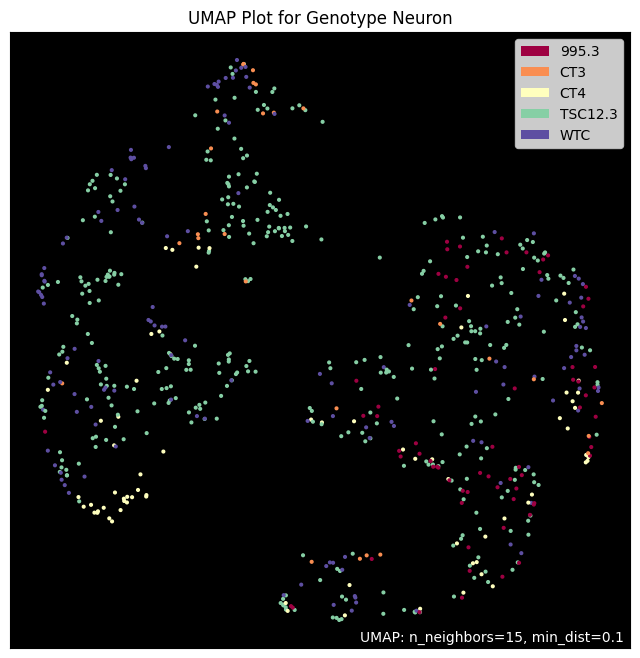

Plotting Culture treatment UMAP...


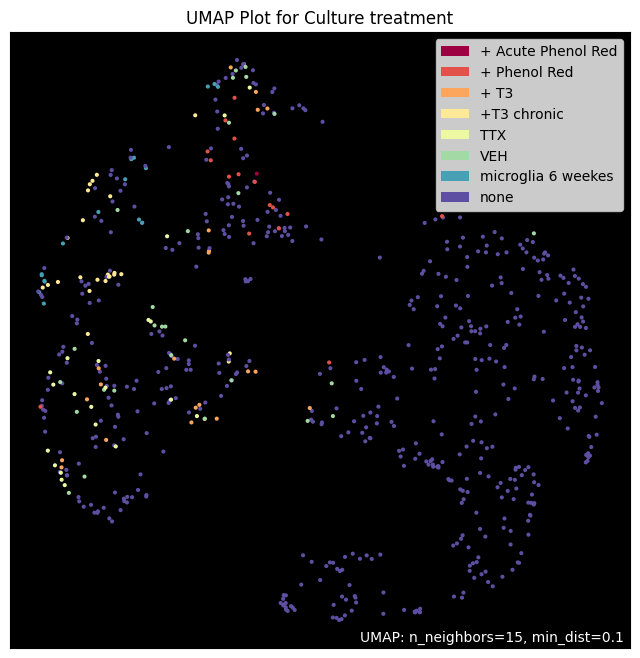

Plotting Batch number UMAP...


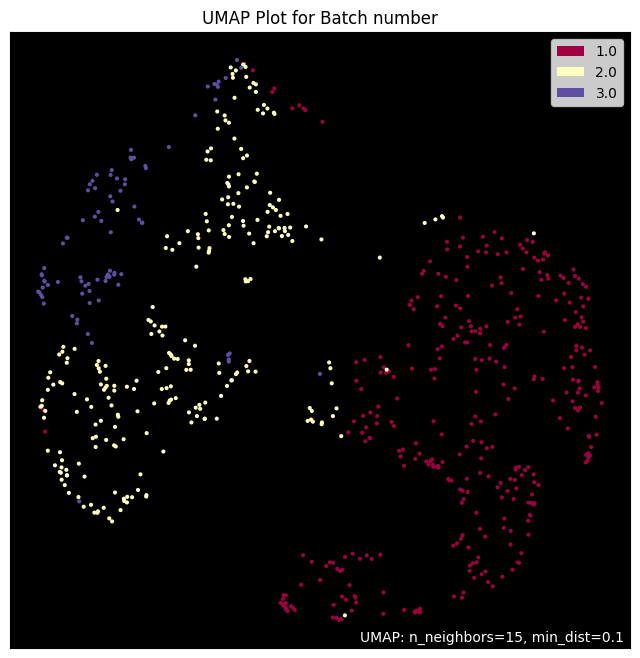

Plotting Batch number UMAP...


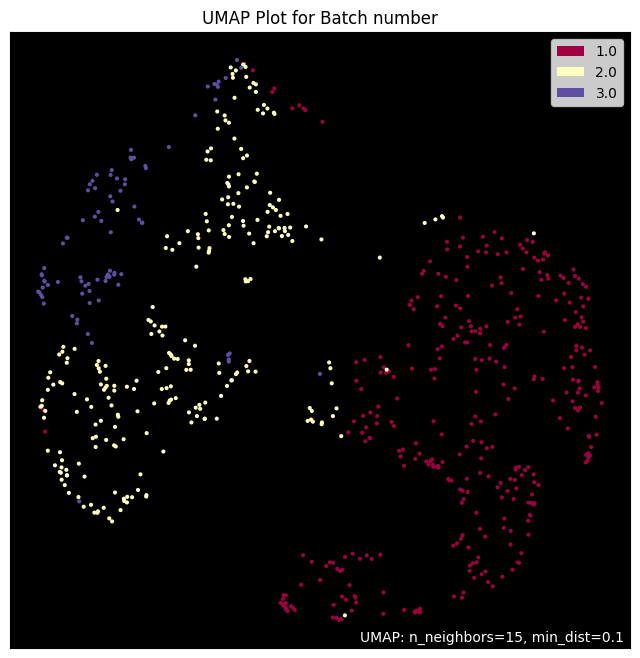

Plotting Cultured by UMAP...


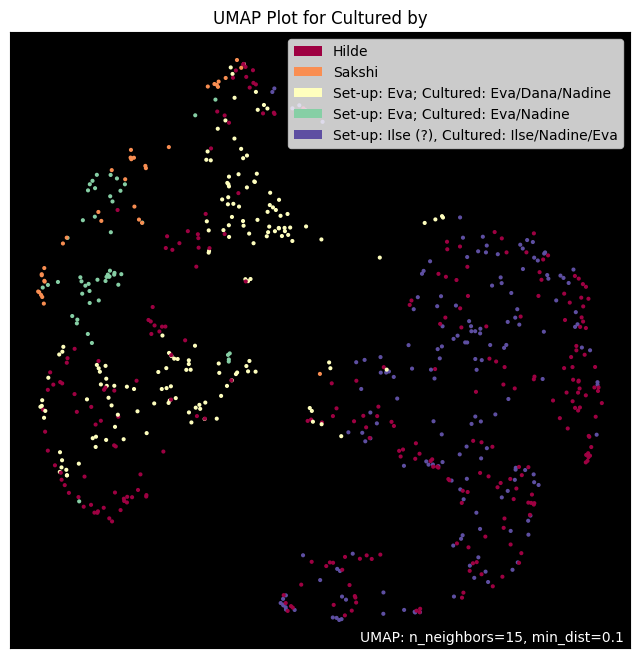

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap

data_extracted_features_imputed_UMAP_labeled = data_extracted_features_imputed.copy() 

# data_extracted_features_imputed_kmeans_labeled_features = data_extracted_features_imputed_kmeans_labeled.drop(columns=['Div calculated'])
# div_column = data_extracted_features_imputed_kmeans_labeled['Div calculated']

# label_encoder = LabelEncoder()
# data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'] = label_encoder.fit_transform(data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'].astype(str))  
# genotype_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))  
# print(f"Original values: {' '.join(label_encoder.classes_)}\n Label encoded values: {data_extracted_features_imputed_kmeans_labeled['Genotype Neuron'].unique()}")
# data_extracted_features_imputed_kmeans_labeled['Culture treatment'] = label_encoder.fit_transform(data_extracted_features_imputed_kmeans_labeled['Culture treatment'])  
# culture_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print(f"Original values: {' '.join(label_encoder.classes_)}\n Label encoded values: {data_extracted_features_imputed_kmeans_labeled['Culture treatment'].unique()}")

data_extracted_features_imputed_UMAP_labeled_features_numeric = data_extracted_features_imputed_UMAP_labeled.select_dtypes(include=['float64', 'int64'])   

# print(data_extracted_features_imputed_kmeans_labeled_features_numeric)
# print(genotype_dict)
# print(culture_dict)

#print(data_extracted_features_imputed_kmeans_labeled)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_extracted_features_imputed_UMAP_labeled_features_numeric)

# kmeans = KMeans(n_clusters=4, random_state=0)
# kmeans.fit(scaled_features)

# clusters = kmeans.predict(scaled_features)

# data_extracted_features_imputed_kmeans_labeled['cluster'] = clusters

np.random.seed(42)

#umap_model = umap.UMAP(n_components=2, random_state=0).fit(scaled_features)
#umap_df = pd.DataFrame(data=umap_model, columns=['UMAP1', 'UMAP2'])

umap_model = umap.UMAP(random_state=42).fit(scaled_features)
# mapper2 = umap.UMAP().fit(data_extracted_features_imputed_UMAP_labeled_features_numeric)

object_columns = object_columns.insert(-1, "Batch number")
print(object_columns)

for feature in object_columns: 
    print(f"Plotting {feature} UMAP...") 
    if not os.path.exists('run_1/UMAP'):
        os.makedirs('run_1/UMAP')
    umap.plot.points(umap_model, labels=data_extracted_features_imputed_UMAP_labeled[feature].astype(str), theme='viridis')
    plt.title(f'UMAP Plot for {feature}')
    plt.savefig(f"run_1/UMAP/{'_'.join(feature.split(' '))}_UMAP.png")
    plt.show()  

# umap.plot.points(umap_model, labels=data_extracted_features_imputed_kmeans_labeled['Batch number'])
# umap_df['Cluster'] = kmeans.labels_

# plt.figure(figsize=(18, 8))
# plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], cmap='viridis')
# plt.legend(data_extracted_features_imputed_kmeans_labeled["Genotype Neuron"].unique(), title="Genotype Neuron")

# # plt.gca().add_artist(legend1)

# plt.title('KMeans Clusters (UMAP)')
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')
# # plt.legend(title='Batch number', loc='best', labels=data_extracted_features_imputed_kmeans_labeled['Batch number']) 
# plt.show()

# print(data_extracted_features_imputed_kmeans_labeled[['Div calculated', 'cluster']].groupby('cluster').mean())

# plt.figure(figsize=(20, 6))
# # sns.boxplot(data=data_extracted_features_imputed_kmeans_labeled, x=data_extracted_features_imputed_kmeans_labeled['Div calculated'], y=data_extracted_features_imputed_kmeans_labeled['Capacitance'])
# sns.scatterplot(data=data_extracted_features_imputed_kmeans_labeled["cluster"])
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('K-Means Clustering')
# plt.legend(labels=['Cluster 0', 'Cluster 1'], loc='upper right', title='Cluster')
# plt.show()


## Validatie (template perhaps?)

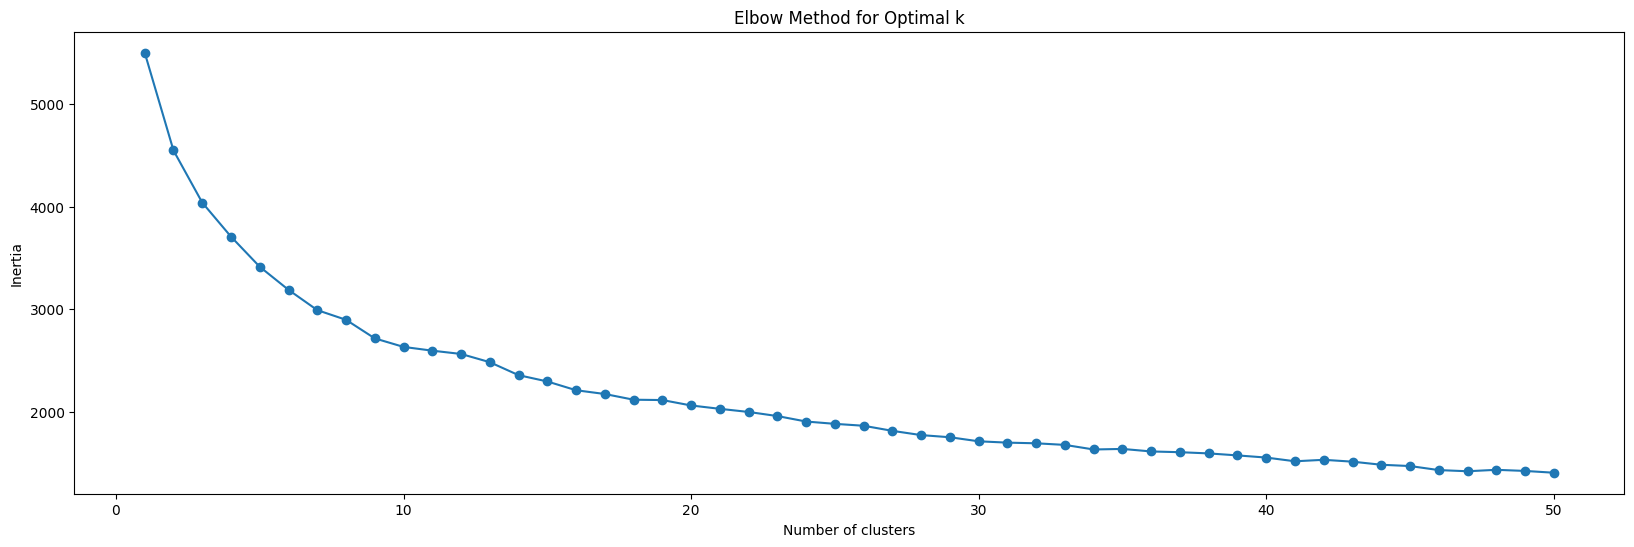

In [ ]:
inertias = []
for k in range(1, 51):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(20, 6))
plt.plot(range(1, 51), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.163946225367548
